cuda:0
start new training with model  resnet101
training at  0
length of train loader 473
Loss Validation  1.9477	Validation accuaracy 15.138	
Epoch: [  0][  0/473]	Train Loss 1.9219	Train Accuaracy 15.625	
Epoch: [  0][100/473]	Train Loss 1.9085	Train Accuaracy 19.338	
Epoch: [  0][200/473]	Train Loss 1.8912	Train Accuaracy 22.093	
Epoch: [  0][300/473]	Train Loss 1.8701	Train Accuaracy 24.522	
Epoch: [  0][400/473]	Train Loss 1.8549	Train Accuaracy 26.130	
length of validaiton loader 220
better model!


training at  1
length of train loader 473
Loss Validation  1.9023	Validation accuaracy 22.471	
Epoch: [  1][  0/473]	Train Loss 1.8627	Train Accuaracy 21.875	
Epoch: [  1][100/473]	Train Loss 1.7570	Train Accuaracy 32.302	
Epoch: [  1][200/473]	Train Loss 1.7390	Train Accuaracy 32.914	
Epoch: [  1][300/473]	Train Loss 1.7274	Train Accuaracy 33.088	
Epoch: [  1][400/473]	Train Loss 1.7165	Train Accuaracy 33.627	
length of validaiton loader 220
better model!


training at  2
length of t

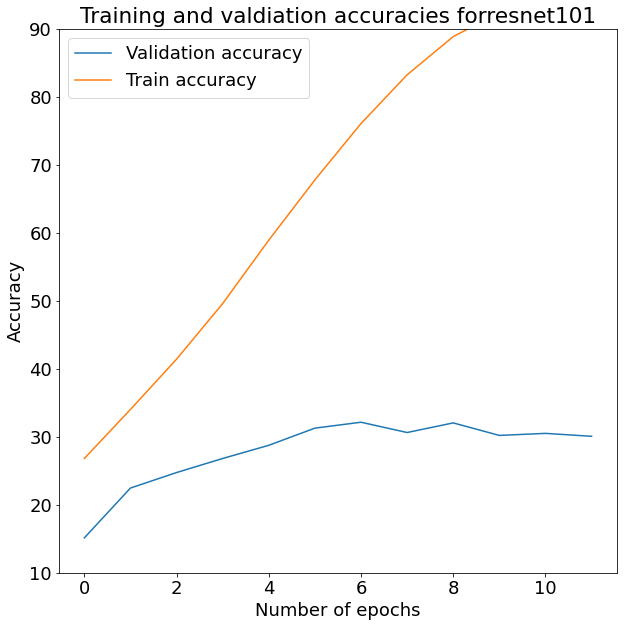

start new training with model  resnet152
training at  0
length of train loader 473
Loss Validation  1.9507	Validation accuaracy 14.167	
Epoch: [  0][  0/473]	Train Loss 1.9203	Train Accuaracy 21.875	
Epoch: [  0][100/473]	Train Loss 1.8923	Train Accuaracy 22.030	
Epoch: [  0][200/473]	Train Loss 1.8762	Train Accuaracy 23.165	
Epoch: [  0][300/473]	Train Loss 1.8657	Train Accuaracy 24.419	
Epoch: [  0][400/473]	Train Loss 1.8523	Train Accuaracy 25.546	
length of validaiton loader 220
better model!


training at  1
length of train loader 473
Loss Validation  1.8986	Validation accuaracy 22.956	
Epoch: [  1][  0/473]	Train Loss 1.6892	Train Accuaracy 46.875	
Epoch: [  1][100/473]	Train Loss 1.7681	Train Accuaracy 31.033	
Epoch: [  1][200/473]	Train Loss 1.7628	Train Accuaracy 31.188	
Epoch: [  1][300/473]	Train Loss 1.7516	Train Accuaracy 32.216	
Epoch: [  1][400/473]	Train Loss 1.7399	Train Accuaracy 32.871	
length of validaiton loader 220
better model!


training at  2
length of train lo

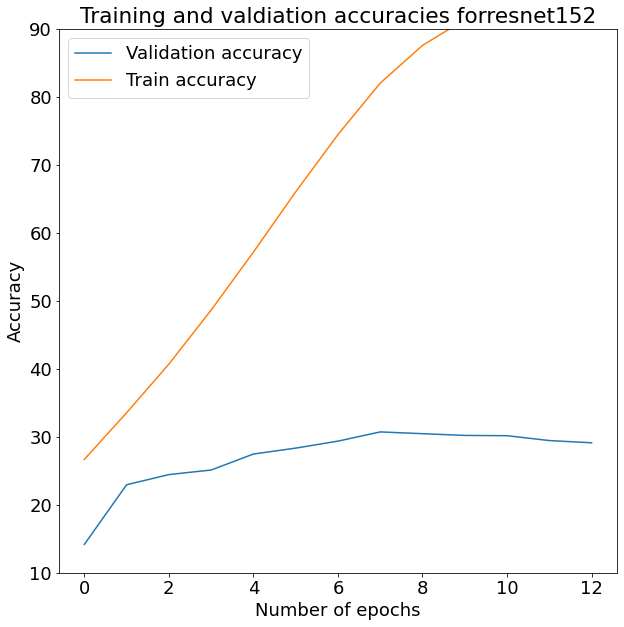

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
import argparse
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.models as models
import load
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import matplotlib
#check if we have a gpu to use it
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

#batch of images for training
batchsize_train=32
#batch of images for evaluation
batchsize_eval=32
#number of frame taken from each video per input
numberOfFrames=3
#learing rate (change the step size and it can be specified by a trial error process)
lr=0.0001
#nb of times that we repeat our training on the data set
epochs=200

#check how many time the loss doesn't change and then stop training
stoppingCriteria=5
#convert the emotion strings to nb
cat2Label={ "Happy": 0,"Angry": 1,  "Disgust": 2, "Fear": 3,"Sad": 4,"Neutral": 5,"Surprise": 6}

#get the image and apply the data augmentation process by resizing it to 224*224; fix the image variations radomly (rotate the image, fix the zooming, translate its location and add black and white)
transformTrain=transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(),transforms.RandomAffine(10, translate=[0.1,0.1], scale=[0.9, 1.25], shear=0.01), transforms.ToTensor()])
#get the image and apply the data augmentation process by resizing it to 224*224; tensor: array in pytoch
transformValidation=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

root_train = './data/face/train_afew'
list_train = './data/txt/afew_All.txt'

root_eval = './data/face/val_afew'
list_eval= './data/txt/afew_eval.txt'
# load the data set
train_loader, val_loader = load.frames3average(root_train, list_train, batchsize_train, root_eval, list_eval, batchsize_eval,numberOfFrames,cat2Label, transformTrain,transformValidation)

#the train function get the images, the structure that we want to optimize, the optimizer, the loss function and the epoch
def train(train_loader, model, optimizer,loss_fn, epoch):
    #average meter: the sum values to create the elements
    losses = load.AverageMeter()
    accuaracy = load.AverageMeter()
    #tell my model that we are training so the weights will change
    model.train()
    #input_var: the entered arrage; target_var: the label(emotion); path:path of the video; index:specify the index to create a map of the videos
    for i, (input_var, target_var,path,index) in enumerate(train_loader):
        
        target_var = target_var.float().to(DEVICE)
        #convert the input_vat from a python list to a pytorch tensor
        input_var=torch.stack(input_var,4)

        input_var = input_var.to(DEVICE)

        #Feed forward command (go from the input to the label)
        pred_score = model(input_var)
        
        #loss and accuaracy computation
        loss = loss_fn(pred_score, target_var.long()).sum()
        acc_iter = discreteAccuracy(pred_score.data, target_var)
        #update the values after every training
        losses.update(loss.item(), input_var.size(0))
        accuaracy.update(acc_iter, input_var.size(0))
    
    	#Backpropagation process (changing the weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('Epoch: [{:3d}][{:3d}/{:3d}]\t'
                      'Train Loss {loss.avg:.4f}\t'
                      'Train Accuaracy {accuaracy.avg:.3f}\t'
                    .format(
                    epoch, i, len(train_loader), loss=losses, accuaracy=accuaracy))

    return losses.avg,accuaracy.avg


def discreteAccuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)  # first position is score; second position is pred.
    pred = pred.t()  # .t() is T of matrix (256 * 1) -> (1 * 256)
    correct = pred.eq(target.view(1, -1).expand_as(pred))  # target.view(1,2,2,-1): (256,) -> (1, 2, 2, 64)

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res[0]


def val(val_loader, model,loss_fn,classes):
    
    lossesVal = load.AverageMeter()
    accuaracyVal = load.AverageMeter()

    #tell the code that we don't need to change the weight
    model.eval()
    #tell the code to not compute the gradiant
    with torch.no_grad():
        for i, (input_var, target_var,path,index) in enumerate(val_loader):          
            target_var = target_var.float().to(DEVICE)
        
            input_var=torch.stack(input_var,4)
           
            input_var = input_var.to(DEVICE)
            pred_score = model(input_var)

            loss = loss_fn(pred_score, target_var.long()).sum()
            acc_iter = discreteAccuracy(pred_score.data, target_var)
            
            lossesVal.update(loss.item(), input_var.size(0))
            accuaracyVal.update(acc_iter, input_var.size(0))

            if i == (len(val_loader)-1):
                print('Loss Validation  {loss.avg:.4f}\t'
                      'Validation accuaracy {accuaracy.avg:.3f}\t'
                    .format(loss=lossesVal, accuaracy=accuaracyVal))
    

    return accuaracyVal.avg,lossesVal.avg

#define my loss function
loss_fn = nn.CrossEntropyLoss()
predictionsForPlot=[]

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
#define the structure
class model_extended(nn.Module):
    def __init__(self, submodel,ninputs):
        super(model_extended, self).__init__()
        self.submodel=submodel
        #get the average pooling
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier=nn.Linear(ninputs,7)
        self.submodel.fc=nn.Identity()

    def forward(self, x):
        #print(x.size())
        #change dimention order
        x=x.permute(0,4,1,2,3)
        #check each dimension size
        batch_size, seqlen, nc, h, w = x.size()
        #combine the batch size and sequence lenght together
        x = x.reshape(-1, nc, h, w)

        f=self.submodel(x)
        #reduce the 30 values to 10 (each value has 3 emotion scores)
        out = f.reshape(batch_size, seqlen, -1)
        #average the result on the 3 images from the same video
        out=out.mean(1)
        #
        #print(out.size())
        out=self.classifier(out)
        return out



      


#load the structure of the model and add them in a list
modelsList=[]
resnet18 = models.resnet18(pretrained=True)
modelsList.append(resnet18)
resnet34 = models.resnet34(pretrained=True)
modelsList.append(resnet34)
resnet50 = models.resnet50(pretrained=True)
modelsList.append(resnet50)
resnet101 = models.resnet101(pretrained=True)
modelsList.append(resnet101)
resnet152 = models.resnet152(pretrained=True)
modelsList.append(resnet152)
#'resnet18','resnet34','resnet50',
modelsName=['resnet101','resnet152']
#512,512,2048,
#2048 is the size of the last feature vector
ninputslist=[2048,2048]
#load each time model and training it
for submodel,name,ninputs in zip(modelsList,modelsName,ninputslist):
    
    model=model_extended(submodel,ninputs)
    
    print("start new training with model ",name)
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr, momentum=0.9, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.2)
    model.cuda()  
    best_prec1=0
    predicitionsval=[]
    predictionstrain=[]
    
    lossestrain=[]
    worseCount=0
    lossesval=[]
    
    

    #how many times we need to repeat the training
    for epoch in range(epochs):
        print("training at ", epoch)
        ######Traind and validating###########################

        print("length of train loader",len(train_loader))
        #call the validation function
        validationAccuaracy,lossValidation = val(val_loader, model,loss_fn,cat2Label)
        #call the training function
        loss_train,train_accuaracy=train(train_loader, model, optimizer,loss_fn, epoch)

        print("length of validaiton loader",len(val_loader))
        
        lossestrain.append(loss_train)
        lossesval.append(lossValidation)
        predictionstrain.append(train_accuaracy.item())
        predicitionsval.append(validationAccuaracy.item())

        ######Savind Best Model###############################
        is_best = validationAccuaracy > best_prec1
        if is_best:
            worseCount=0
            print('better model!\n\n')
            pathModelSave="networksaving/"+"net_"+str(validationAccuaracy)
            torch.save(model.state_dict(), pathModelSave)
            best_prec1=validationAccuaracy
        else:
            print("model didnt improve \n\n")
            worseCount+=1

        lr_scheduler.step()
        if(worseCount==stoppingCriteria):
            print("training done\n\n\n")
            matplotlib.rcParams.update({'font.size': 18})
            plt.figure(figsize=(10,10))
            plt.plot(predicitionsval,label="Validation accuracy")
            plt.plot(predictionstrain,label="Train accuracy")
            plt.ylim([10,90])
            plt.ylabel("Accuracy")
            plt.xlabel("Number of epochs")
            plt.legend()
            plt.title("Training and valdiation accuracies for"+name)
            plt.savefig("ramisave/graph_"+name+".jpeg")
            plt.show()
            break
        